<a href="https://colab.research.google.com/github/shakasom/spatialjoin-python/blob/master/spatial%20join%20python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# How to quickly join data by location in Python - Spatial join
## How to do spatial join easily in Python and Why it is a powerful tool often ignored in data science.

The chances are high that you have joined two tables if you have used Pandas Library. It is incredible how easy it is to combine two different datasets that share columns. But do you know that there is an easy way to join tables (DataFrames) based on locations?

## Data and Installation

In [0]:
%%time 
!apt update
!apt upgrade
# Important library for many geopython libraries
!apt install gdal-bin python-gdal python3-gdal 
# Install rtree - Geopandas requirment
!apt install python3-rtree 
# Install Geopandas
!pip install git+git://github.com/geopandas/geopandas.git
# Install descartes - Geopandas requirment
!pip install descartes 

In [0]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

In [0]:
!git clone --recursive https://github.com/shakasom/spatialjoin-python.git

In [3]:
!ls spatialjoin-python/

 data   README.md   requirements.txt  'Spatial Join Airbnp.ipynb'


## Practical Application: An Example with Airbnb Dataset

In [5]:
listings = pd.read_csv("spatialjoin-python/data/stockholm_listings.csv")
gdf_listings = gpd.GeoDataFrame(listings,crs={'init' :'epsg:4326'}, geometry=gpd.points_from_xy(listings.longitude, listings.latitude))
neighborhoods = gpd.read_file("spatialjoin-python/data/stockholm_neighbourhoods.geojson")
gdf_listings.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,geometry
0,145320,In the middle of it all - with a view!,703851,Kim,NaN,Södermalms,59.31364,18.05256,Private room,1272,2,72,2019-06-25,2.54,1,26,POINT (18.05256 59.31364)
1,155220,"Stockholm, new spacoius villa",746396,Madeleine,NaN,Skarpnäcks,59.24667,18.17799,Entire home/apt,1203,3,0,NaN,NaN,2,0,POINT (18.17799 59.24667)
2,155685,Hornstull with water view!,748592,Robert,NaN,Södermalms,59.31535,18.03277,Entire home/apt,3209,4,22,2015-12-01,0.22,1,0,POINT (18.03277 59.31535)
3,164448,Double room in central Stockholm with Wi-Fi,784312,Li,NaN,Södermalms,59.31268,18.06258,Private room,597,3,311,2019-09-26,3.13,2,140,POINT (18.06258 59.31268)
4,170651,Petit Charm Rooftop next to heaven,814021,Marie,NaN,Södermalms,59.31568,18.03138,Entire home/apt,734,3,33,2019-09-01,0.33,1,216,POINT (18.03138 59.31568)


In [6]:

neighborhoods.head()

,neighbourhood,neighbourhood_group,geometry
0,Kungsholmens,None,"MULTIPOLYGON (((17.97420 59.31400, 17.97834 59..."
1,Östermalms,None,"MULTIPOLYGON (((18.03773 59.37062, 18.03850 59..."
2,Bromma,None,"MULTIPOLYGON (((17.86463 59.34295, 17.86848 59..."
3,Skärholmens,None,"MULTIPOLYGON (((17.86352 59.27468, 17.86779 59..."
4,Södermalms,None,"MULTIPOLYGON (((18.01142 59.32212, 18.01579 59..."


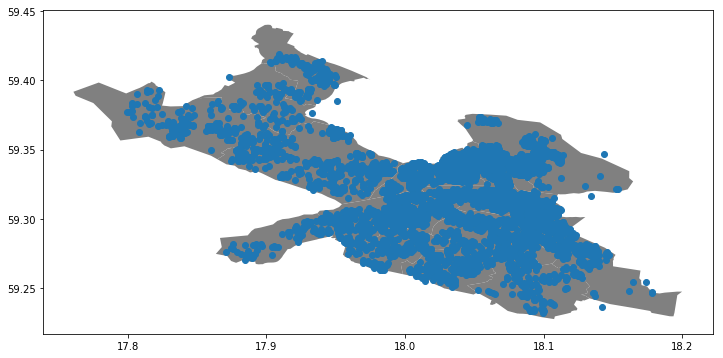

In [8]:
fig, ax = plt.subplots(figsize=(12,10))
neighborhoods.plot(color="Gray", ax= ax);
gdf_listings.plot(ax=ax);

In [9]:
stockholm_areas = gpd.read_file("spatialjoin-python/data/stockholm_areas.geojson")
stockholm_areas.head()

,fid,Deso,Total,KOMMUNNAMN,KATEGORI,ADAT,geometry
0,3705.0,0180C3410,1278.0,Eker?,Kommun,None,"MULTIPOLYGON (((17.97999 59.32128, 17.97794 59..."
1,5287.0,0180C4470,1783.0,Solna,Kommun,1912-12-12T12:00:00,"MULTIPOLYGON (((18.01529 59.34032, 18.01584 59..."
2,5288.0,0180C4730,2029.0,Solna,Kommun,1912-12-12T12:00:00,"MULTIPOLYGON (((18.00308 59.34115, 18.00447 59..."
3,5301.0,0180C4580,2254.0,Solna,Kommun,1912-12-12T12:00:00,"MULTIPOLYGON (((17.99797 59.34043, 17.99876 59..."
4,5302.0,0180C4600,1738.0,Solna,Kommun,1912-12-12T12:00:00,"MULTIPOLYGON (((18.01505 59.34042, 18.01505 59..."


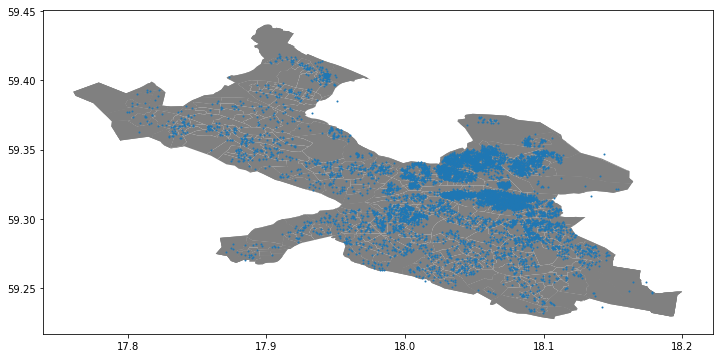

In [11]:
fig, ax = plt.subplots(figsize=(12,10))
stockholm_areas.plot(color="Gray", ax= ax);
gdf_listings.plot(ax=ax, markersize=1);

## Spatial Join

Let us say we are interested in counting the number of listings per the voting area (voting districts). Although it is not readily available in our columns, we can do this easily and this where spatial join comes handy. With one line of code, you can determine which point is within each voting district.

In [13]:
stockholm_areas.crs == gdf_listings.crs

True

The below code joins gdf_listings to stockholm_areas based on their locations. The op parameter determines what kind of join you want. In this case, we provided "within" - that determines which area the point belongs. Here is a sample of 5 rows from the joined table.

In [15]:
sjoined_listings = gpd.sjoin(gdf_listings, stockholm_areas, op="within")
sjoined_listings.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,geometry,index_right,fid,Deso,Total,KOMMUNNAMN,KATEGORI,ADAT
0,145320,In the middle of it all - with a view!,703851,Kim,NaN,Södermalms,59.31364,18.05256,Private room,1272,2,72,2019-06-25,2.54,1,26,POINT (18.05256 59.31364),44,6156.0,0180C3310,1543.0,Stockholm,Kommun,None
911,5612474,Best location in Stockholm on Söder,27584743,Liv,NaN,Södermalms,59.31228,18.05465,Entire home/apt,1448,1,3,2015-07-13,0.06,1,0,POINT (18.05465 59.31228),44,6156.0,0180C3310,1543.0,Stockholm,Kommun,None
1359,6829836,Quiet place by the park Tantolunden,18177484,Jörgen,NaN,Södermalms,59.31317,18.05321,Entire home/apt,910,7,0,NaN,NaN,1,0,POINT (18.05321 59.31317),44,6156.0,0180C3310,1543.0,Stockholm,Kommun,None
2414,12718370,Cozy Södermalm apartment with a view,5287593,Erika,NaN,Södermalms,59.31269,18.05461,Entire home/apt,685,3,3,2016-08-09,0.08,1,0,POINT (18.05461 59.31269),44,6156.0,0180C3310,1543.0,Stockholm,Kommun,None
2584,13123672,Cozy apartment in the middle of Södermalm,12892927,Selma,NaN,Södermalms,59.31347,18.05291,Entire home/apt,949,7,3,2016-08-05,0.08,1,0,POINT (18.05291 59.31347),44,6156.0,0180C3310,1543.0,Stockholm,Kommun,None


As you can see, this table joins the two based on their locations. We have the attributes of the point as well as which area the point belongs. Now it is easy to count how many listings are in each area with pandas group-by function. We can perform pandas Groupby like this, to get how many listings are in each voting district area.


In [16]:
grouped = sjoined_listings.groupby("Deso").size()
df = grouped.to_frame().reset_index()
df.columns = ['Deso', 'listings_count']
df.head()

,Deso,listings_count
0,0123C1090,2
1,0180C1010,2
2,0180C1020,4
3,0180C1030,16
4,0180C1040,6



We end up with a DataFrame of district area code Deso and listing counts in each area.

Notice that this grouped data is a Dataframe. If you want to have it with Voting areas dataset, you can simply use pandas merge function based on "Deso" column on both Dataframes.

In [17]:
merged_areas = stockholm_areas.merge(df, on='Deso', how='outer')
merged_areas.head()

,fid,Deso,Total,KOMMUNNAMN,KATEGORI,ADAT,geometry,listings_count
0,3705.0,0180C3410,1278.0,Eker?,Kommun,None,"MULTIPOLYGON (((17.97999 59.32128, 17.97794 59...",12.0
1,6307.0,0180C3410,1278.0,Stockholm,Kommun,None,"MULTIPOLYGON (((17.97999 59.32128, 17.97794 59...",12.0
2,5287.0,0180C4470,1783.0,Solna,Kommun,1912-12-12T12:00:00,"MULTIPOLYGON (((18.01529 59.34032, 18.01584 59...",60.0
3,6050.0,0180C4470,1783.0,Stockholm,Kommun,None,"MULTIPOLYGON (((18.01529 59.34032, 18.01584 59...",60.0
4,5288.0,0180C4730,2029.0,Solna,Kommun,1912-12-12T12:00:00,"MULTIPOLYGON (((18.00308 59.34115, 18.00447 59...",28.0


The result of the merge is GeoDataFrame which you can plot geographically. The following is Choroplpleth map for the number of listings in each voting district.

In [19]:
merged_areas.shape[0] == stockholm_areas.shape[0]

True

/usr/local/lib/python3.6/dist-packages/matplotlib/colors.py:512: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


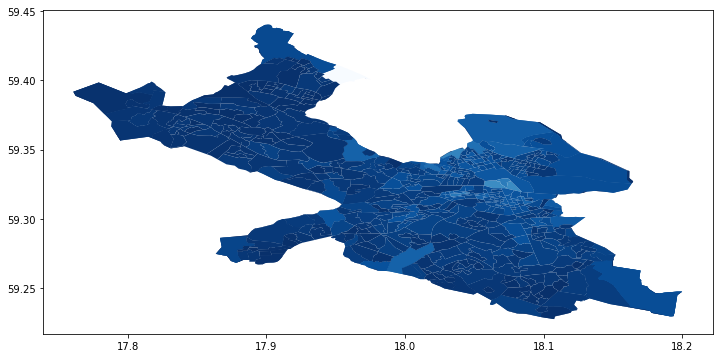

In [20]:
merged_areas.plot(column="listings_count", cmap="Blues_r", figsize=(12,10));